# DS-GA 1003, Spring 2020, Section 2
# Stastistical Learning Theory

Artie Shen, Sreyas Mohan, CDS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn import linear_model
from scipy.stats import norm
import matplotlib.mlab as mlab
%matplotlib inline

#### Generic Utility Functions

In [2]:
def plot_prediction_function(f_list = None, label_list = None, data = None, alpha = 0.9, include_data_x = False,
                            x_label=None, y_label=None):
    """
    Util function that visualizes a dataset
    """
    plt.figure(figsize=(20,10))
    
    if data is not None:
        x_min, x_max = np.min(data[:, 0]), np.max(data[:, 0])
    else:
        x_min, x_max = -5.0, 5.0;
        
    if ( (f_list is not None) and (label_list is not None) ):
        x_array = np.arange(x_min, x_max, 0.1);
        if include_data_x:
            x_array = np.concatenate([x_array, data[:, 0], data[:, 0]+0.001, data[:, 0]-0.001])
            x_array = np.sort(x_array)


        for f, label in zip(f_list, label_list):
            f_y = f(x_array);
            plt.plot(x_array, f_y, label=label);
    
    if data is not None:
        plt.scatter(data[:, 0], data[:, 1], alpha = alpha )
        
    if label_list is not None:
        plt.legend()
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
    plt.show()

# 1. Generative Model for Data

We will work on a regression problem in this lab. 

The input, action and output space will be $\mathcal{R}$. 

The output $y$ is related to the input $x$ as 

$$ y = g(x) = ax^2 + bx + c $$

where 

$$ a \sim \mathcal{N}(\mu_a, \sigma_a) $$
$$ b \sim \mathcal{N}(\mu_b, \sigma_b) $$
$$ c \sim \mathcal{N}(\mu_c, \sigma_c) $$

Assume that $X \sim \mathcal{N}(\mu_x, \sigma_x)$. 

For the purposes of this lab, let's set $\mu_a = 1, \mu_b = 2, \mu_c = 3, \mu_x = 0$ and $\sigma_a = \sigma_b = \sigma_c = \sigma_x = 1$. 

#### Utility functions for sampling

In [3]:
mu_a = 1;
sigma_a = 1;

mu_b = 2;
sigma_b = 1; 

mu_c = 3;
sigma_c = 1;

mu_x = 0;
sigma_x = 1;

assert( (mu_x == 0) and (sigma_x == 1))

#### Exercise: complete the code below

In [5]:

def template_g(coeff_list, x):
    """
    Construct a polynomial of x with coeff_list 
    @param coeff_list: [c0,c1,c2,...,cn] note that the order is reversed
    @return: c0 + c1*x + c2*x^2 + ... + cn * x^n 
    """
    ans = 0;
    ## FILL IN YOUR CODE HERE ##
    return ans

In [6]:
# for example, 3*2^2 + 2*2 + 1 = 17
template_g([1,2,3], 2)

17

#### Exercise: complete the code below

In [8]:
def sample_g():
    """
    Function that samples from the given Gaussian distributions for a,b,c
    @return: an callable object that can be used to calculate y given x
    """
    # draw a sample from N(\mu_a, \sigma_a) for a,b,c
    ## FILL IN YOUR CODE HERE ##
    a = ...
    b = ...
    c = ...
    return partial(template_g, [c, b, a] )

In [9]:
# the output of sample_g is the function g(x) where a,b,c has been sampled
# you can pass x into g(x) to find the y value associated with this x
g_x = sample_g()
g_x(1)

7.41643704249115

#### Exercise: complete the code below

In [10]:
def get_one_x_y_sample():
    """
    Function that provide one sample from the given generative process
    @return: (x,y)
    """
    ## FILL IN YOUR CODE HERE ##
    x = ...
    g = sample_g()
    return x, g(x)

In [11]:
x,y = get_one_x_y_sample()
print(x,y)

-0.2261404998257916 2.5608311389721203


In [12]:
## gives a matrix with first column x and second column y
def generate_n_samples(n = 1000):
    """
    Function that generates multiple samples
    @return: a (n,2) numpy matrix
    """
    matrix = np.zeros([n, 2]);
    for i in range(n):
        matrix[i] = get_one_x_y_sample();
    return matrix

In [13]:
nsamples = generate_n_samples(100)
print(nsamples.shape)
print(nsamples[0])
print(nsamples[1])

(100, 2)
[0.29954124 5.25629292]
[0.76215003 5.87649908]


### Visualizing samples from $\mathcal{P}_{X \times Y}$

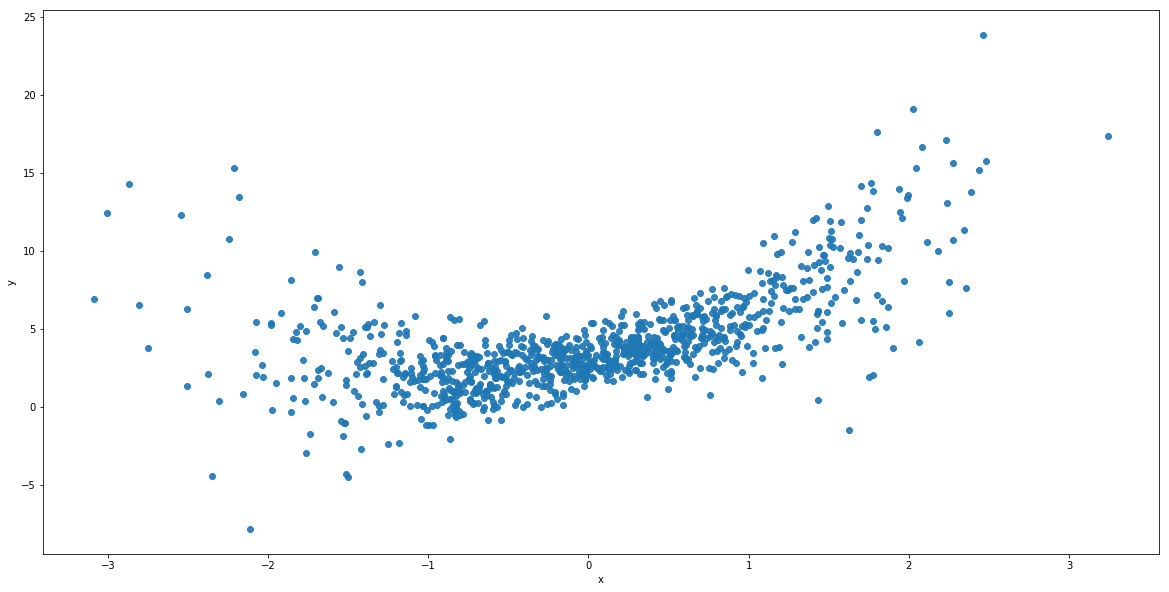

In [14]:
data_cloud =  generate_n_samples(1000)
plot_prediction_function(data = data_cloud, x_label="x", y_label="y")

### Visualizing samples of $Y$ for fixed values of $X$

Let's say we have a fixed set of input $X$ and for each $x \in X$, we randomly draw n_sample_per_x sets of $a,b,c$ and compute the corresponding y values.

In [15]:
def y_for_fixed_x( x_list = np.arange(-4, 4.5, 0.5), n_sample_per_x = 10):
    """
    For each sample of x, generate n_sample_per_x setting of [a,b,c], and return corresponding g(x)
    """
    data = np.zeros([len(x_list)*n_sample_per_x, 2]);
    for i, x in enumerate(x_list):
        for j in range(n_sample_per_x):  
            g = sample_g();
            data[n_sample_per_x*i + j, 0] = x;
            data[n_sample_per_x*i + j, 1] = g(x);
    return data

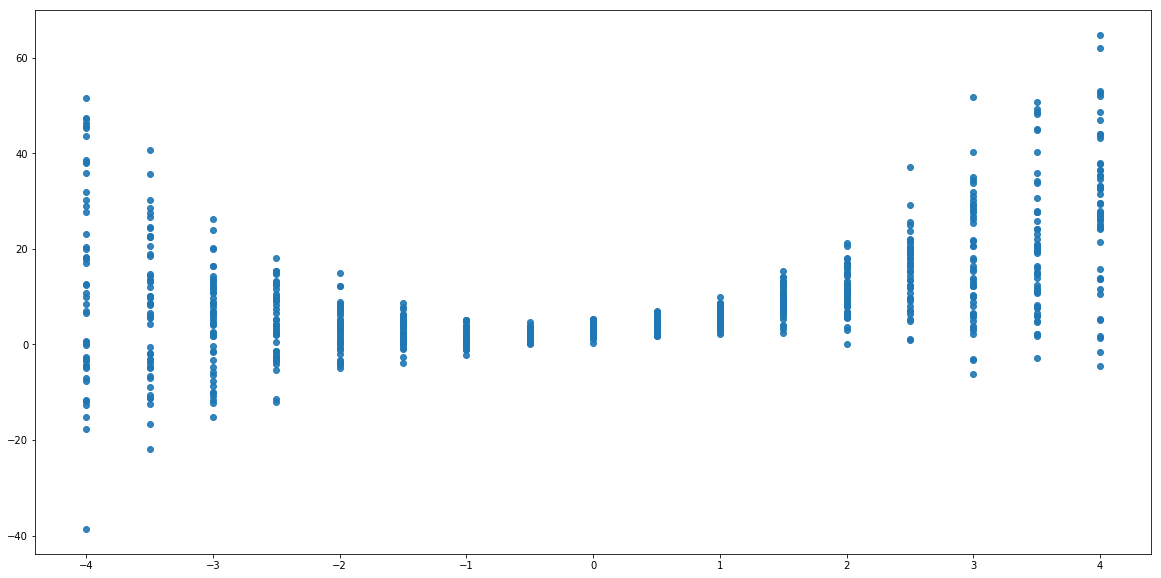

In [16]:
plot_prediction_function(data = y_for_fixed_x(n_sample_per_x=50) )

# 2. Bayes Risk:

Recall that the risk of a function $f$ wrt to loss $l$: 
$$R(f) = E[l(f(x), y)]$$ 
and the bayes optimal function:
$$f^* = \underset{f}{\operatorname{argmin}}R(f)$$ 

Hints:
$$R(f) = E[(f(x) - E[y|x])^2 ] + E[(y - E[y|x])^2] $$
 
Given that $x \sim \mathcal{N}(\mu_x, \sigma_x)$ and $\mu_x=0, \sigma_x=1$:
$$E[X] = \mu_x = 0$$
$$E[X^2] = \mu_x^2 + \sigma_x^2 = 1$$
$$E[X^3] = \mu_x(\mu_x^2 + 3\sigma_x^2) = 0$$
$$E[X^4] = \mu_x^4 + 6\mu_x^2\sigma_x^2+3\sigma_x^4 = 3$$




### Question:

1. Let's assume we want to  minimize l2 loss, that is $l(f(x),y)=(f(x)-y)^2$. What is the bayes optimal function $f^*(x)$ for the model described above? Does your answer depend on the distribution assumed on $X$?

2. What is the risk assosciated with $f^*(x)$, $R(f)$?

3. Once you have mathematical expressions for 1 and 2, fill in the python functions below for the bayes prediction function and bayes risk. 

### Answers:

1. For l2 loss, $f^*(x) = E[Y|X=x] = \mu_a x^2 + \mu_b x + \mu_c $. No, independent of distribution on $X$.
2. From the decomposition of l2 loss above, 
$$ \begin{align}
        R(f^*(x)) &= E[(y - E[y|x])^2] \\
                  &= E_x[ E_{y|x} [ (y - E[y|x])^2 ] ] \\
                  &= E_x[ \sigma_a^2 x^4 + \sigma_b^2 x^2 + \sigma_c^2 ] \\
                  &= \sigma_a^2 (3) + \sigma_b^2 ( \sigma_x^2 + \mu_x^2) + \sigma_c^2 \\
                  &= 5
   \end{align} $$
   


The optimal function $f^*(x)$ that minimizes the risk.

In [17]:
f_star = partial(template_g, [mu_c, mu_b, mu_a] )

The numerical value of the Bayes Risk $R(f^*(x))$.

In [18]:
bayes_risk = sigma_a**2 * 3  + sigma_b**2 * ( sigma_x**2 + mu_x**2) + sigma_c**2;
print(bayes_risk)

5


Let's draw $f^*(x)$ on the dataset.

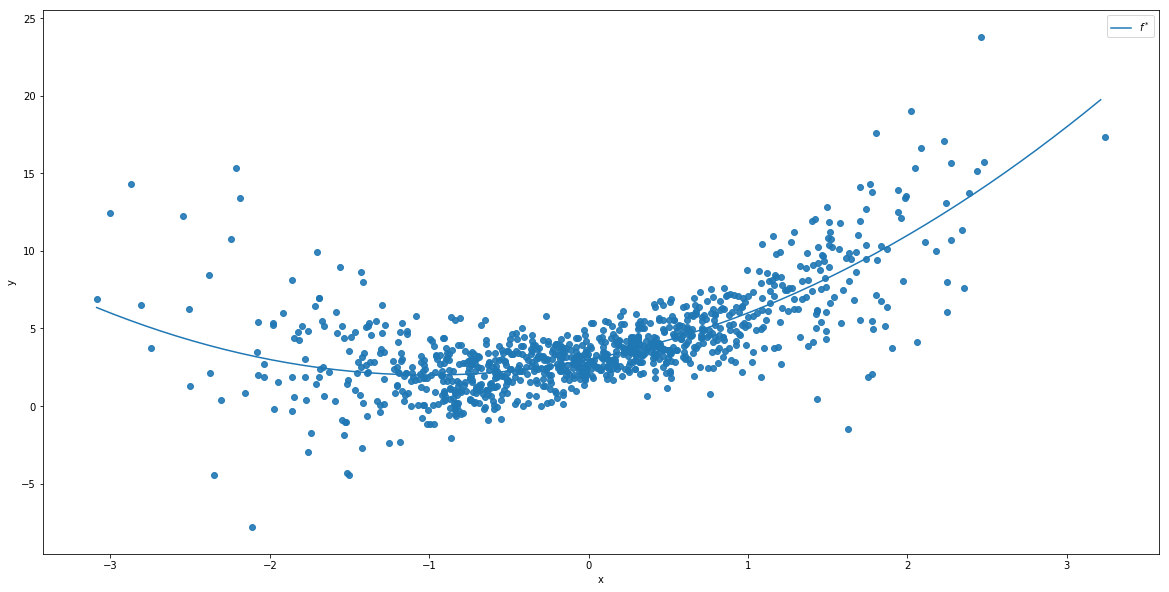

In [19]:
plot_prediction_function([f_star], ['$f^*$'], data=data_cloud, x_label="x", y_label="y")

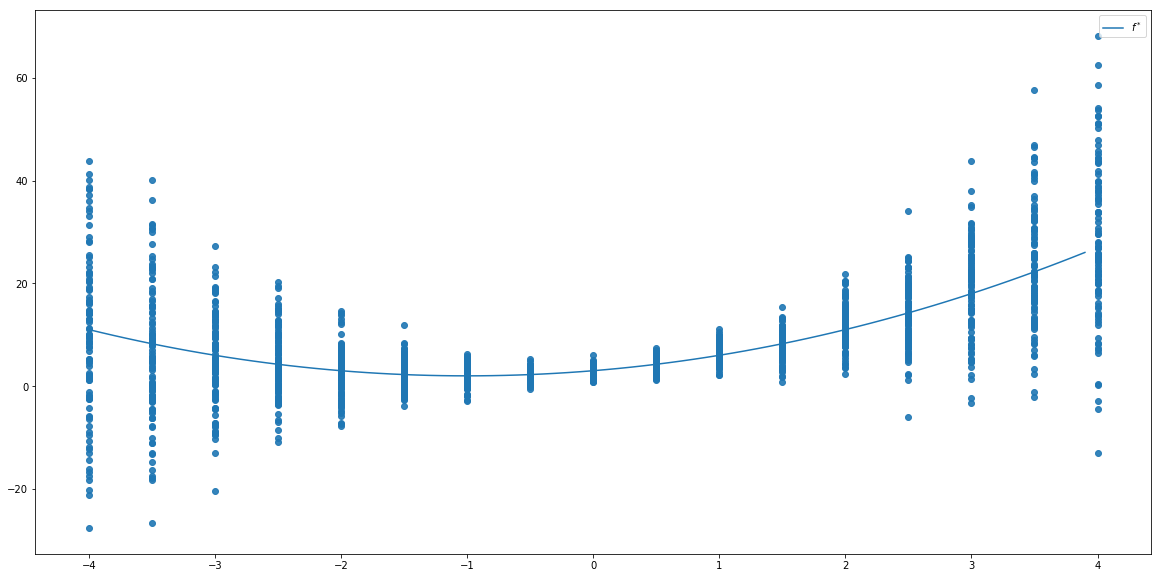

In [20]:
plot_prediction_function([f_star], ['$f^*$'], data=y_for_fixed_x(n_sample_per_x=100) )

## Estimating the Risk $R(f)$ using Monte Carlo

Now that we know the theatrical value for the $R(f^*(x))$, can we verify its correctness on the dataset.

Please complete the code block below with following logics:
- draw a sample $x_i, y_i$ from the generative distribution $\mathcal{P}_{X,Y}$ using get_one_x_y_sample() function
- apply $f(x)$ (an input variable) on $x_i$ to derive the prediction $f(x_i)$
- compute the l2 loss between $f(x_i)$ and $y_i$
- repeat the above steps many times and calculate the average loss

#### Exercise: complete the code below

In [21]:
def estimate_risk(f, n_try = int(1e5) ):
    """
    Function that calculate the average l2 loss on the generative distribution
    @param f: a function f(x)
    @param n_try: number of iterations
    @return: the average loss across all iterations
    """
    sum = 0;
    ## FILL IN YOUR CODE HERE ##
    return sum/n_try

With large value of n_try you should get average loss that is close to 5.

In [22]:
estimate_risk(f_star)

5.018283946545662

# 3. Empirical Risk 

In reality, we never know $\mathcal{P}_{X, Y}$ and we work with finite samples drawn from the distribution.

With $\mathcal{D}_n = \{ (x_1, y_1), (x_2, y_2), \dots , (x_n, y_n) \}$ be $n$ iid data points, the empirical risk of $f$ with respect to loss $l$ on dataset $\mathcal{D}_n$ is defined as $$ \hat{R}_n(f) = \frac{1}{n} \sum_{i=1}^{n} l( f(x_i), y_i) $$

Have we used the expression of $ \hat{R}_n(f) $ for anything till now?

Answer:
We estimated risk in monte carlo simulation using the same expression. 

### Exercise:

1. Is $\hat{R}_n(f)$ or $R(f)$ a random variable? If so, what is the mean of the random variable and what is it's distribution? 
2. Can $R(f) \geq  \hat{R}_n(f)$?



Answers:

1. $\hat{R}_n(f)$ is random variable with the mean $R(f)$. Approximately gaussian using CLT.
2. Yes

In [23]:
def empirical_risk(f, sample_matrix):
    fy_array = f(sample_matrix[:, 0]);
    risk = np.mean((fy_array - sample_matrix[:, 1]) ** 2)
    return risk

#### Checking the distribution of $\hat{R}_n(f)$

In [24]:
n = 1000;
emp_rsk = np.zeros(n)
for i in range(n):
    emp_rsk[i] = empirical_risk(f_star, generate_n_samples(5000))
    
print( np.mean(emp_rsk) )

4.992659896694226


How does the distribution of $\hat{R}_n(f^*(x))$ look like?

/Users/Melancardie/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


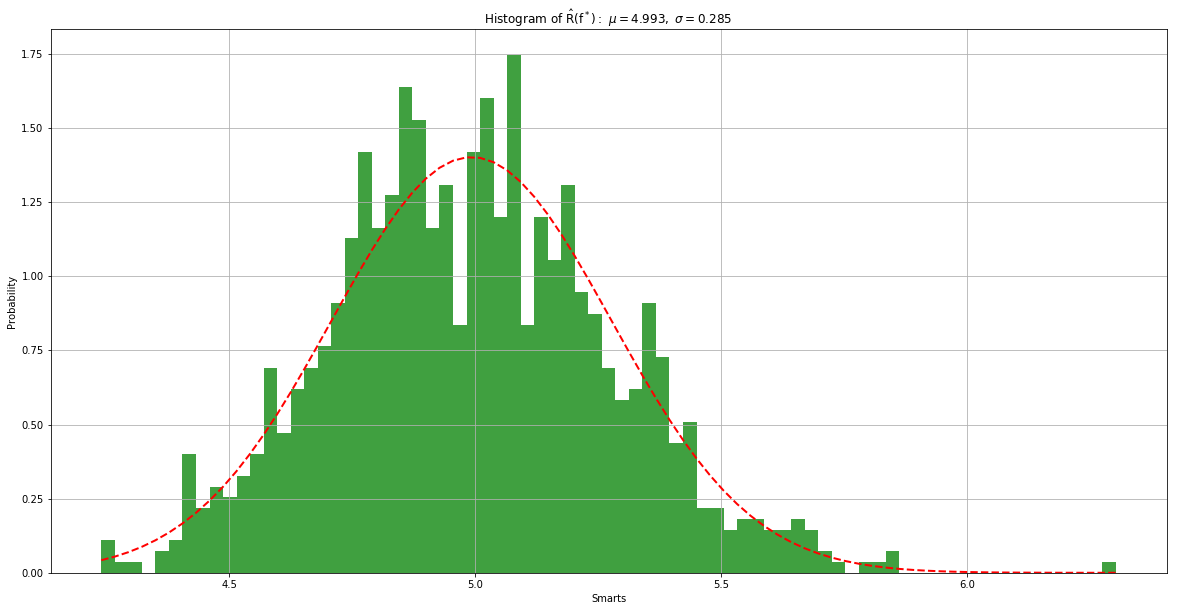

In [25]:
datos = emp_rsk
plt.figure(figsize=(20,10))
# best fit of data
(mu, sigma) = norm.fit(datos)

# the histogram of the data
n, bins, patches = plt.hist(datos, 75, density=True, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ \hat{R}(f^*):}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()



# 4. Empirical Risk Minimization

Let's fix a training data with $n = 100$ points

In [26]:
data = generate_n_samples(n = 100);

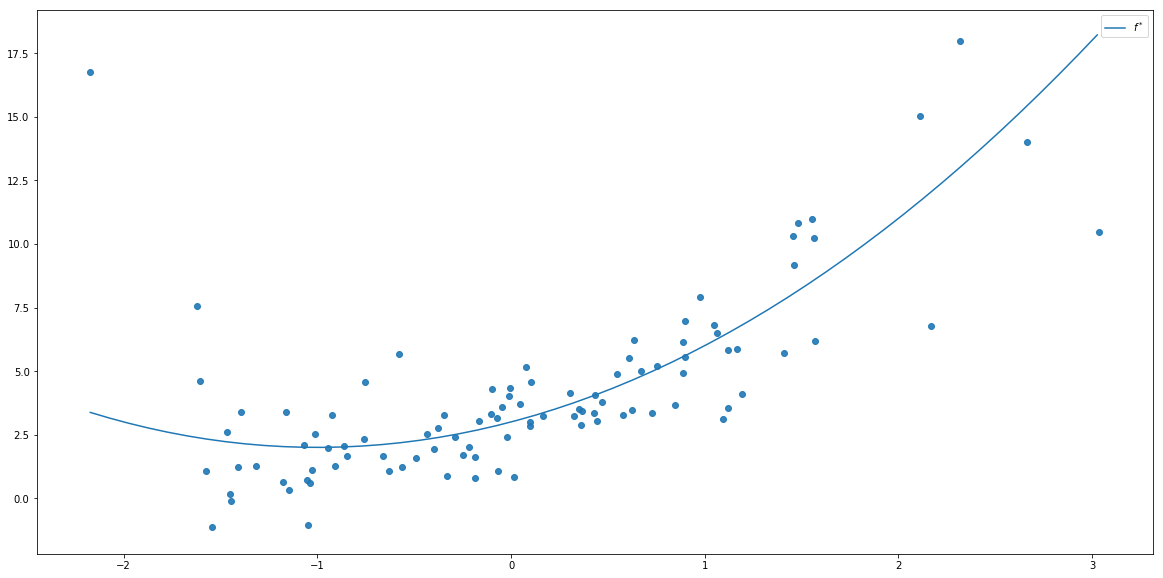

In [27]:
plot_prediction_function([f_star], ['$f^*$'], data)

## Model 1: memorizing the training data

One way to achieve $\hat{R}_n(f) = 0 $ is to memorize the data. 

For the sake of simplicity let's assume that the $\mathcal{D}_n$ we are working with has no duplicate values for $x$. 

The function $f(x)$ returns the corresponding $y$ from $\mathcal{D}_n$ otherwise $f(x)$ returns $0$:

$$f(x) = \begin{cases}
    y_i & x \in \mathcal{D}_n \\
    0              & otherwise
\end{cases}$$

### Exercise
What is the risk, $R(f)$, for this function?

Answer:

$$ \begin{align}
        R(f) &= E[ (Y - 0) ^2 ] \\
             &= E_{X} E_{Y|X=x} E[ Y^2 ] \\
             &= E_{X} ( var(Y|X=x) + E[Y|X=x]^2 ) \\
             &= E_{X} ( \sigma_a^2 X^4 + \sigma_b^2 X^2 + \sigma_c^2 + (\mu_a X^2 + \mu_b X + \mu_c )^2 ) \\  
             &= E_{X} ( (\sigma_a^2 + \mu_a^2) X^4 + (\alpha)X^3 + (\sigma_b^2 + \mu_b^2 + 2 \mu_c \mu_a ) X^2 + \beta X + \sigma_c^2 + \mu_c^2 \\
             &= 3(\sigma_a^2 + \mu_a^2) + (\sigma_b^2 + \mu_b^2 + 2 \mu_c \mu_a ) + \sigma_c^2 + \mu_c^2
   \end{align} $$

In [28]:
risk_memorized_function = 3*(sigma_a**2 + mu_a**2) + (sigma_b**2 + mu_b**2 + 2*mu_c*mu_a) + sigma_c**2 + mu_c**2
print(risk_memorized_function)

27


Let's code up a dummy model that memorizes the training data.

In [29]:
def f_memorized(x_array):
    scalar = False
    if not isinstance(x_array,(list,np.ndarray)):
        scalar = True
        x_array = np.array([x_array]);
        
    result = np.zeros_like(x_array).astype(float)
    for i, x in enumerate(x_array):
        found = False
        for x_i, y_i in data:
            if x==x_i:
                result[i] = y_i;
                found = True
        if not found:
            result[i] = 0.0
            
    if scalar:
        return result[0]
    return result

Let's compare the empirical risk (on the training set) and estimated risk (against the $\mathcal{P}_{X,Y}$)

In [30]:
linear_f_hat_risk = estimate_risk( f_memorized, n_try=int(1e3) ) 
print('Risk: ', linear_f_hat_risk)
linear_f_hat_empirical_risk = empirical_risk(f_memorized, data)
print('Empirical Risk: ', linear_f_hat_empirical_risk)

Risk:  25.189270242806355
Empirical Risk:  0.0


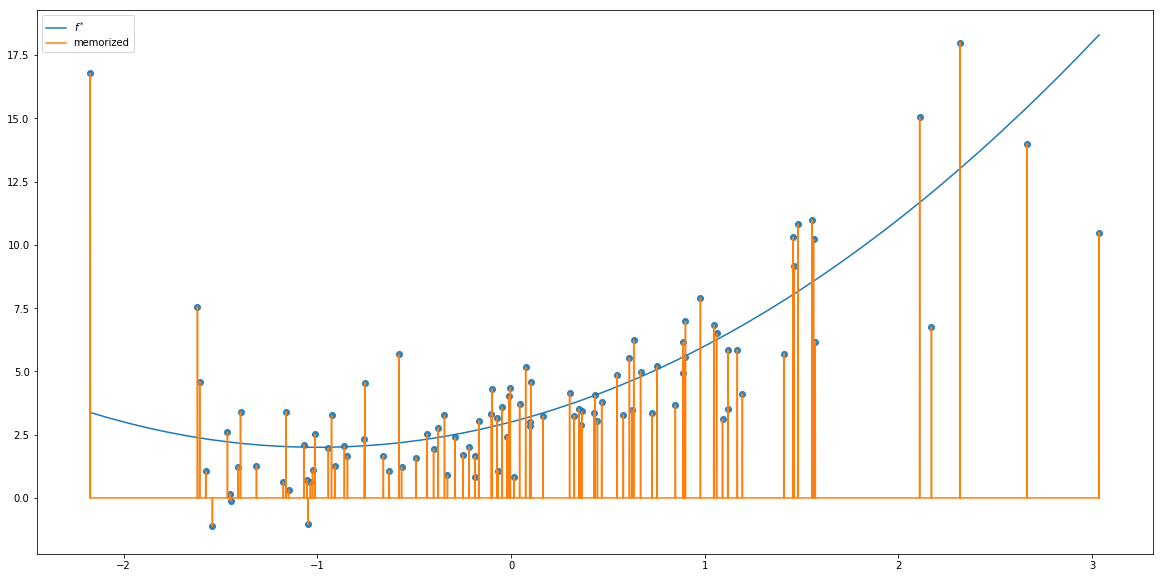

In [31]:
plot_prediction_function([f_star, f_memorized], ['$f^*$', 'memorized'], data, include_data_x=True)

## Model 2: Linear (Affine) Hypothesis Space

Like we saw in the previous section, (unconstrained) empirical risk minimization is (almost) useless in practise. We achieved perfect $0$ for empirical risk but we have a increase in the actual risk, which is the quantity we care about. 

In this part, we would like to construct a linear model: $$f(x) = \alpha x + \beta$$

## Exercise
1. Calculate an expression for risk of $f(x)$
2. Find $\alpha^*, \beta^*$ which minimises $R(f)$.

Answer:
1. 

$$ \begin{align}
        R(f) &= E[ (Y - \alpha X - \beta )^2 ] \\
             &= E_{X} E_{Y|X=x} E[ (Y - \alpha x - \beta )^2 ] \\
             &= E_{X} ( var( (Y - \alpha x - \beta )|X=x) + E[(Y - \alpha x - \beta )|X=x]^2 ) \\
             &= E_{X} ( \sigma_a^2 X^4 + \sigma_b^2 X^2 + \sigma_c^2 + (\mu_a X^2 + (\mu_b - \alpha) X + (\mu_c - \beta) )^2 ) \\  
             &= E_{X} ( (\sigma_a^2 + \mu_a^2) X^4 + (something)X^3 + (\sigma_b^2 + (\mu_b - \alpha)^2 + 2 (\mu_c - \beta) \mu_a ) X^2 + (something) X + \sigma_c^2 + (\mu_c - \beta)^2 \\
             &= 3(\sigma_a^2 + \mu_a^2) + (\sigma_b^2 + (\mu_b - \alpha)^2 + 2 (\mu_c - \beta) \mu_a ) + \sigma_c^2 + (\mu_c - \beta)^2
     \end{align} $$ 

 2.
     
 To find $\alpha^*, \beta^*$
 $$  \frac{d}{d \alpha}R(f) = 2(\alpha - \mu_b)  = 0 $$
 Therefore, $\alpha^* = \mu_b$
 $$  \frac{d}{d \beta}R(f) = -2 \mu_a + 2(\beta - \mu_c) = 0 $$
 $\beta^* = \mu_a + \mu_c$
 

Compute the risk for this linear model

In [32]:
def linear_function_risk(alpha, beta):
    return 3*(sigma_a**2 + mu_a**2) + sigma_b**2 + (mu_b-alpha)**2 + 2*(mu_c - beta)*mu_a + sigma_c**2 + (mu_c - beta)**2;    

Let's construct the $f^*_{\mathcal{H}}(x)$ for this linear model.

In [33]:
linear_f_star = partial(template_g, [mu_a + mu_c, mu_b]);

Compare the theoretical value of the risk with the estimated risk value.

In [34]:
### Estimating Risk
mc_linear_f_star_risk = estimate_risk( linear_f_star) 
print('MC Risk: ', mc_linear_f_star_risk)

linear_f_star_risk = linear_function_risk(mu_b, mu_a + mu_c)
print('Risk :' , linear_f_star_risk)

MC Risk:  7.043203575792982
Risk : 7


Let's visualize $\ \ f^*_\mathcal{H}$ on the dataset

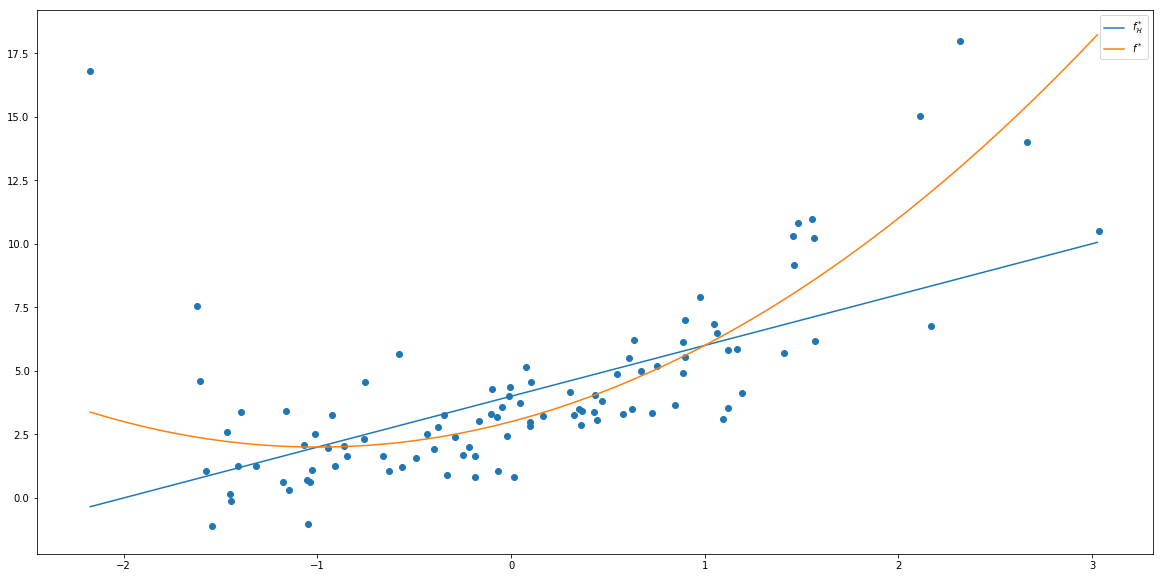

In [35]:
plot_prediction_function([linear_f_star, f_star], ['$f^*_\mathcal{H}$', '$f^*$'], data, alpha = 1)

## Empirical Risk Minimization using Sklearn

Now let's fit a linear regression model using Sklearn.

See the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Please make sure that fit_intercept=True

#### Exercise: complete the code below

In [36]:

train_x = data[:, 0:1]
train_y = data[:, 1]
reg = ## FILL IN THE CODE HERE ##

Let's compare the $\alpha^*$ and $\beta^*$ with the coefficients learned by sklearn.

Note that these two sets of numbers might differ.

In [37]:
print(mu_a + mu_c, mu_b)
print(reg.intercept_, reg.coef_)

4 2
4.030917117926544 [2.08215476]


In [38]:
linear_f_hat = partial(template_g, [reg.intercept_, reg.coef_[0]])

For the parameters learned by Sklearn, let's compare: 
- the theoretical risk 
- the esimated risk 
- the empirical risk on the training set

In [39]:
linear_f_hat_risk = linear_function_risk(reg.coef_[0], reg.intercept_)
print('Risk :' , linear_f_hat_risk)
mc_linear_f_hat_risk = estimate_risk( linear_f_hat ) 
print('Estimated Risk: ', mc_linear_f_hat_risk)
linear_f_hat_empirical_risk = empirical_risk(linear_f_hat, data)
print('Empirical Risk: ', linear_f_hat_empirical_risk)

Risk : 7.007705272266173
Estimated Risk:  6.997187658843758
Empirical Risk:  7.421015367488712


### Visualizing Prediction Function $\ \ \hat{f}_\mathcal{H}$

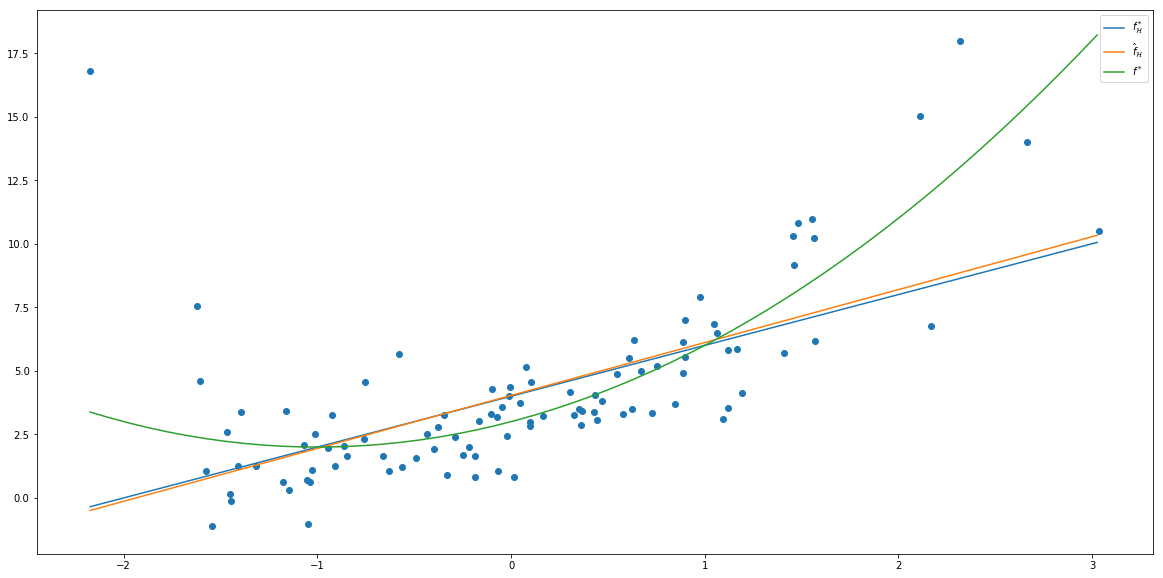

In [40]:
plot_prediction_function([linear_f_star, linear_f_hat, f_star], ['$f^*_\mathcal{H}$', '$\hat{f}_\mathcal{H}$', '$f^*$'], data, alpha = 1)

# 5. Additional Questions

1. Suppose we use another hypothesis space $\mathcal{H}' \subset \mathcal{H}$, how do you expect the approximation error to change?
2. Suppose we increase the number of data points $n$ in the sample to calculate $\ \hat{f}_\mathcal{H}$. How do we expect estimation error to change?
2. Repeat everything we did for linear hypothesis space for constant, quadratic and cubic hypothesis space for $n=500, 1000$ as well - does your results match with what you expected in 1 and 2?